# Unpaired Sample T-test Notebook

Load libraries

In [46]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from numpy import mean
from scipy.stats import sem
from scipy.stats import t
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats import weightstats as statsmodelsweightstats
%matplotlib inline

from collections import Counter

Load data

I will be using a sample dataset.

In [47]:
data = pd.read_excel("student_t_test/data/t-test2.xls", sheet_name ="Independent-sample t-test")
data.head()

,Wear_Amount,Sole_Material_Type
0,13.2,A
1,8.2,A
2,10.9,A
3,14.3,A
4,10.7,A


# Important Variables
So, we have 1 categorical (factor) variable which is Sole_Material_Type. And we have 1 quantitative variable which is Wear_Amount.

# Question
Is there a statistically significant difference between A and B on their Wear_Amount?

# hypothesis 
H0: There's no difference in Wear_Amount between A and B  
Ha: There's a statistically significant difference in Wear_Amount between A and B

# Set alpha
Probability of making type 1 error

In [48]:
# The alpha level will be 0.05.
alpha = 0.05

# Assumptions
Determine if data meets requirements to perform an independent samples t-test.


Assumption #1: Your dependent variable should be measured on a continuous scale.   
Assumption #2: Your independent variable should consist of two categorical, independent groups.   
Assumption #3: You should have independence of observations.    
Assumption #4: There should be no significant outliers.    
Assumption #5: Your dependent variable should be approximately normally distributed for each group of the independent variables.    
Assumption #6: There needs to be homogeneity of variances.

# Check missing values

In [49]:
#Lets Look At Missing Data
total = data.isnull().sum().sort_values(ascending=False)
percent_1 = data.isnull().sum()/data.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total Missing', '%'])
missing_data.loc[missing_data['Total Missing'] > 0].head(33)

,Total Missing,%


Okay, we don't have missing values

# Distribution of Scores in each Type

In [50]:
a_data = data.loc[data['Sole_Material_Type'] == 'A']
b_data = data.loc[data['Sole_Material_Type'] == 'B']

# Type Summaries

In [51]:
print('************Type A Summary******************')
a_data['Wear_Amount'].describe()

************Type A Summary******************


count    10.000000
mean     10.630000
std       2.451326
min       6.600000
25%       8.975000
50%      10.750000
75%      12.625000
max      14.300000
Name: Wear_Amount, dtype: float64

In [52]:
print('************Type B Summary******************')
b_data['Wear_Amount'].describe()

************Type B Summary******************


count    10.000000
mean     11.040000
std       2.518465
min       6.400000
25%       9.425000
50%      11.250000
75%      13.150000
max      14.200000
Name: Wear_Amount, dtype: float64

# Check and Remove significant outliers

In [53]:
def detect_outliers(df, n, features):
        """
        Takes a dataframe df of features and returns a list of the indices
        corresponding to the observations containing more than n outliers according
        to the Tukey method.
        """
        outlier_indices = []

        # iterate over features(columns)
        for col in features:
            # 1st quartile (25%)
            Q1 = np.percentile(df[col], 25)
            # 3rd quartile (75%)
            Q3 = np.percentile(df[col],75)
            # Interquartile range (IQR)
            IQR = Q3 - Q1

            # outlier step
            outlier_step = 1.5 * IQR

            # Determine a list of indices of outliers for feature col
            outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index

            # append the found outlier indices for col to the list of outlier indices
            outlier_indices.extend(outlier_list_col)

        # select observations containing more than 2 outliers
        outlier_indices = Counter(outlier_indices)
        multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )

        return multiple_outliers

In [54]:
detect_outliers(data, 0, ['Wear_Amount'])

[]

Again we have significant outliers. Lets check that with boxplot

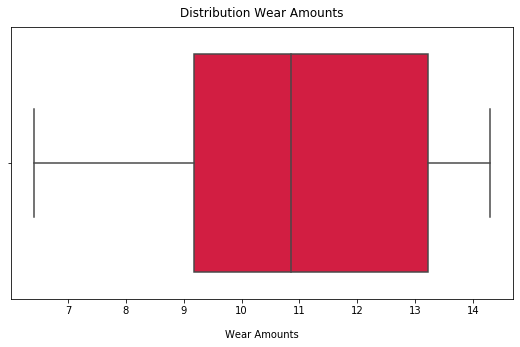

In [55]:
plt.figure(figsize=(9, 5))
sns.boxplot(data['Wear_Amount'], color='crimson', saturation=0.9)
plt.title("Distribution Wear Amounts", y=1.015)
plt.xlabel("Wear Amounts", labelpad=14);

# Normality Law

Visualize distribution to check normality

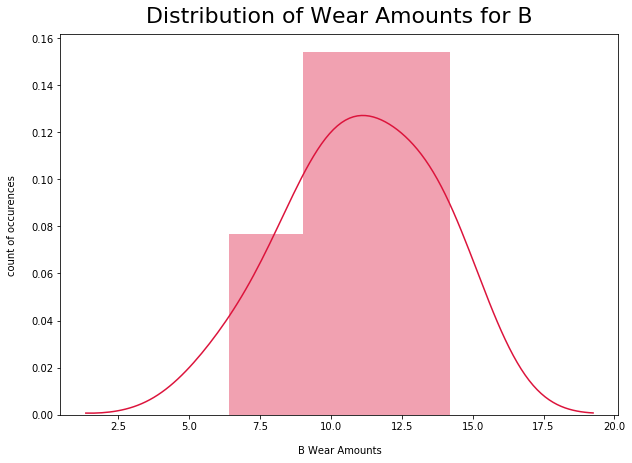

In [56]:
plt.figure(figsize=(10, 7))
sns.distplot(b_data['Wear_Amount'], color='crimson')
plt.title("Distribution of Wear Amounts for B", y=1.015, fontsize=22)
plt.xlabel("B Wear Amounts", labelpad=14)
plt.ylabel("count of occurences", labelpad=14);

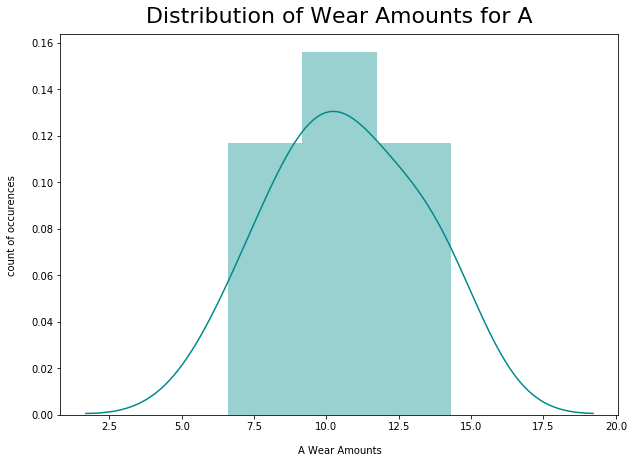

In [57]:
plt.figure(figsize=(10, 7))
sns.distplot(a_data['Wear_Amount'], color='darkcyan')
plt.title("Distribution of Wear Amounts for A", y=1.015, fontsize=22)
plt.xlabel("A Wear Amounts", labelpad=14)
plt.ylabel("count of occurences", labelpad=14);

In [58]:
# Shapiro-Wilk normality test for group A
stats.shapiro(a_data.Wear_Amount.dropna())

(0.9624006152153015, 0.8128618597984314)

In [59]:
# Shapiro-Wilk normality test for group B
stats.shapiro(b_data.Wear_Amount.dropna())

(0.9481486678123474, 0.6466502547264099)

Shapiro-Wilk test for normality of each group not significant which indicates that the groups have approximately a normal distibution.


# homogeneity

In [60]:
stats.levene(data['Wear_Amount'][data['Sole_Material_Type'] == 'A'],
             data['Wear_Amount'][data['Sole_Material_Type'] == 'B'])

LeveneResult(statistic=0.01126580661642599, pvalue=0.9166448330605479)

Levene’s test for homogeneity of variance is not significant which indicates that the groups have approximately equal variances.

Let's now compare the means using boxplot of both genders

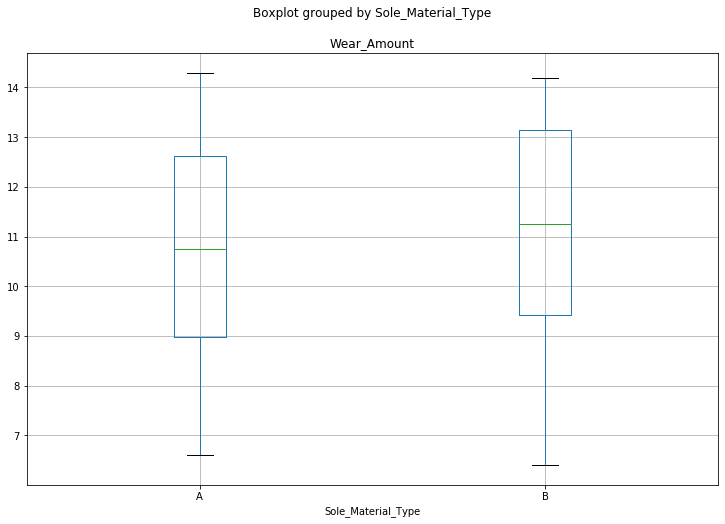

In [61]:
#Create a boxplot
data.boxplot('Wear_Amount', by='Sole_Material_Type', figsize=(12, 8))

ctrl = data['Wear_Amount'][data.Sole_Material_Type == 'ctrl']

grps = pd.unique(data.Sole_Material_Type.values)
d_data = {grp:data['Wear_Amount'][data.Sole_Material_Type == grp] for grp in grps}

k = len(pd.unique(data.Sole_Material_Type))  # number of conditions
N = len(data.values)  # conditions times participants
n = data.groupby('Sole_Material_Type').size()[0] #Participants in each condition

A only boxplot

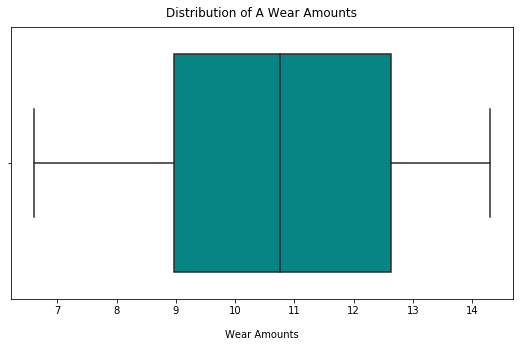

In [62]:
plt.figure(figsize=(9, 5))
sns.boxplot(a_data['Wear_Amount'], color='darkcyan', saturation=0.9)
plt.title("Distribution of A Wear Amounts", y=1.015)
plt.xlabel("Wear Amounts", labelpad=14);

B only boxplot

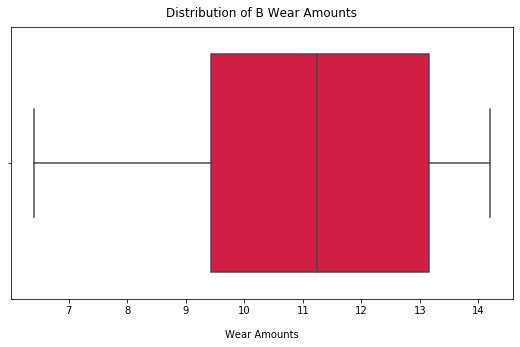

In [63]:
plt.figure(figsize=(9, 5))
sns.boxplot(b_data['Wear_Amount'], color='crimson', saturation=0.9)
plt.title("Distribution of B Wear Amounts", y=1.015)
plt.xlabel("Wear Amounts", labelpad=14);

In [64]:
#Run independent t-test
t,p = stats.ttest_ind(data['Wear_Amount'][data['Sole_Material_Type'] == 'A'], data['Wear_Amount'][data['Sole_Material_Type'] == 'B'])
print('T statistic : {}'.format(t))
print('P value : {}'.format(p))

T statistic : -0.36891055003610973
P value : 0.7164979543716625


# Interpretation 

An unpaired sample t-test was used to analyze the wear amount of shoe sole type to test if the there was a significant difference. The wear amount of type B was higher (11.04 ± 2.52 units) compared to type A wear amount (10.63 ± 2.45 units), but this difference was NOT statistically significant (t(9)=-0.37, p= 0.0.716) of 0.41 units, so we fail to reject the null hypothesis.

Is it tough to determine if this value of 0.41 is considered small or large?. The standard deviations are 2.45 and 2.52 so I think this difference in means of 0.41 at a glance seems relatively large. To combat this uncertainty of the calculation above, we can use the measure of Cohen's d

# Cohen's d
Cohen's d is a measure to determine the standardized mean difference in groups. The measure is the difference in group means in terms of standard deviation units.

In [65]:
a_mean = np.mean(a_data.Wear_Amount)
b_mean = np.mean(b_data.Wear_Amount)
a_standard_deviation = np.std(a_data.Wear_Amount)
b_standard_deviation = np.std(b_data.Wear_Amount)

In [66]:
def interpret_cohens_d(cohens_d):
    """
    Determines text interpretation of effect size given Cohen's d value

    :param cohens_d: float of Cohen's d value
    :returns: effect_size_interpretation: adjective to describe magnitude of effect size
    """
    if 0<=cohens_d<0.1:
        effect_size_interpretation = "Very Small"
    elif 0.1<=cohens_d<0.35:
        effect_size_interpretation = "Small"
    elif 0.35<=cohens_d<0.65:
        effect_size_interpretation = "Medium"
    elif 0.65<=cohens_d<0.9:
        effect_size_interpretation = "Large"
    elif cohens_d >= 0.9:
        effect_size_interpretation = "Very Large"
    return effect_size_interpretation

In [67]:
def two_sample_data_setup_for_cohens_d(mean_1, mean_2, sample_std_dev_1, sample_std_dev_2):
    """
    Creates two normal distributions of data values. 
    Calculates differences in values and standard deviation of list of differences.
    Calculates Cohen's D - equation used in dependent t-tests

    :param mean_1: mean of group one
    :param mean_2: mean of group two
    :param sample_std_dev_1: sample standard deviation of group one
    :param sample_std_dev_2: sample standard deviation of group two
    
    :returns: values_1, values_2, cohens_d: values for group one, values for group two, Cohen's d
    """
    values_1 = np.random.normal(loc=mean_1, scale=sample_std_dev_1, size=3000)
    values_2 = np.random.normal(loc=mean_2, scale=sample_std_dev_2, size=3000)
    differences_group_values = np.subtract(values_1, values_2)
    std_dev_differences_group_values = np.std(differences_group_values, ddof=1)
    cohens_d = round(abs((mean_1 - mean_2)/std_dev_differences_group_values), 2)
    return values_1, values_2, cohens_d

In [68]:
def visualize_distributions(values_1, values_2, cohens_d, cohens_d_interpretation):
    """
    Plots KDE plots of values from values_1 and values_2.
    Inserts Cohen's d value and interpretation in title

    :param values_1: values in group one
    :param values_2: values in group two 
    :param cohens_d: Cohen's d value
    :param cohens_d_interpretation: text to describe magnitude of effect size
    :returns: plot figure
    """
    plt.figure(figsize=(10, 8))
    sns.distplot(values_1, hist=False)
    sns.distplot(values_2, hist=False)
    plt.xlabel("value", labelpad=13)
    plt.ylabel("frequency", labelpad=13)
    plt.title("Distribution of Two Groups with {0} Cohen's d of {1}".format(cohens_d_interpretation, cohens_d), y=1.015, fontsize=22);

In [69]:
two_groups_close_means_small_std_dev = two_sample_data_setup_for_cohens_d(a_mean, b_mean, a_standard_deviation, b_standard_deviation)
values_1 = two_groups_close_means_small_std_dev[0]
values_2 = two_groups_close_means_small_std_dev[1]
cohens_d = two_groups_close_means_small_std_dev[2]
cohens_d_interpretation = interpret_cohens_d(cohens_d)

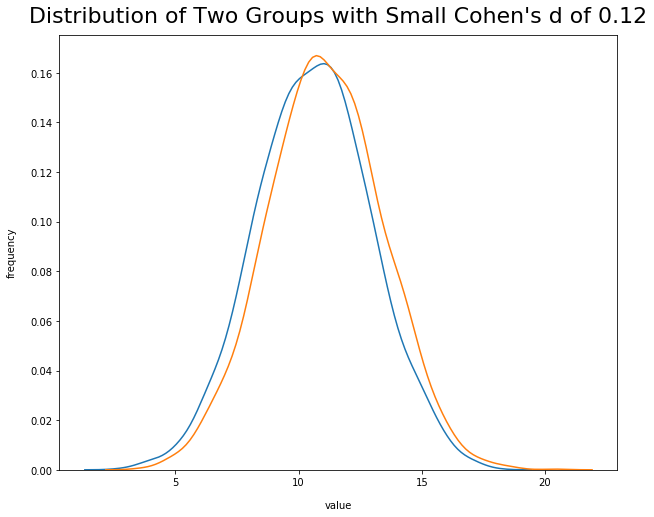

In [70]:
visualize_distributions(values_1, values_2, cohens_d, cohens_d_interpretation)

There's a 0.12 difference in means in terms of sample standard deviation units. The larger the Cohen's d value, the further sample means are from one another in standard deviation units.

In [71]:
print('The Effect size is '+str(interpret_cohens_d(0.12)))

The Effect size is Small


As seen above, the small Cohen's d value of 0.12 means that the sample means are close to one another in standard deviation units. In this test the difference is not statistically significant